In [7]:
import re
import numpy as np
import pandas as pd
import csv
from pprint import pprint
import math

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize



# Plotting tools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
#load training Data
with open('/home/flokla/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20subs_long/idocnade/training.csv', newline='') as csvfile1:
    data_train = pd.read_csv(csvfile1,  names=["Label", "Text"])
    data_train = data_train.dropna(subset=['Text'])   

#load validation Data
with open('/home/flokla/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20subs_long/idocnade/validation.csv', newline='') as csvfile2:
    data_val = pd.read_csv(csvfile2,  names=["Label", "Text"])
    data_val = data_val.dropna(subset=['Text'])     
    
frames = [data_train,data_val]
train_data = pd.concat(frames)

#load testing Data
with open('/home/flokla/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20subs_long/idocnade/test.csv', newline='') as csvfile3:
    data_test = pd.read_csv(csvfile3,  names=["Label", "Text"])  
    data_test = data_test.dropna(subset=['Text'])  

In [9]:
def LdaPipeline(train_fold, val_fold, k):

    dictionary = gensim.corpora.Dictionary(train_fold["Text"].str.split())
    corpus_train = [dictionary.doc2bow(text.split()) for index,text in train_fold["Text"].iteritems()]
    corpus_val = [dictionary.doc2bow(text.split()) for index,text in val_fold["Text"].iteritems()]
    # LDA
    lda_model = gensim.models.LdaMulticore(corpus=corpus_train, id2word = dictionary, num_topics = k, alpha=0.1,workers=15)
    
    # Perplexity
    perplexity = lda_model.log_perplexity(corpus_val)
   
    # Coherence
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus_val]
    coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus_train, texts = texts,coherence='c_v')
    coherence = coherence_model.get_coherence()
    return [2**(-perplexity), coherence]



In [10]:
START = 2
STEP = 1
END = 200


In [11]:
#generate different LDA-Models
coherence_values = []
ppl_values = []
for k in tqdm(range(START, END, STEP)):
    ppl, cv = LdaPipeline(data_train,  data_val,k)
    coherence_values.append(cv)
    ppl_values.append(ppl)

/home/flokla/anaconda3/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/flokla/anaconda3/lib/python3.8/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


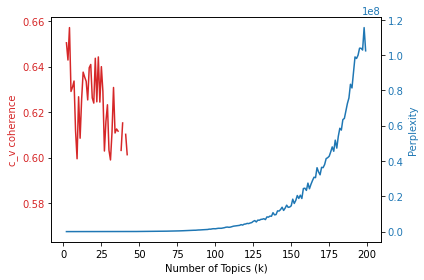

In [12]:
# Show graph

x = range(START, END, STEP)
fig, ax1 = plt.subplots()
#ppls = [math.exp(p) for p in ppl_values]

color = 'tab:red'
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('c_v coherence', color=color)
ax1.plot(x, coherence_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Perplexity', color=color)  
ax2.plot(x, ppl_values, color=color) #use ppls instead of ppl_values for true Perplexity instead of lower bound
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [13]:
maxvalue = max(coherence_values)
print("Maximum Coherence_Value in the list is:", maxvalue)
#Now we have find the position of Max Value
maxpos = coherence_values.index(maxvalue)
print("This value is achieved when using k = "+str(2+maxpos)+" topic-clusters")

Maximum Coherence_Value in the list is: 0.6571986776097919
This value is achieved when using k = 4 topic-clusters


In [14]:
# Evaluate Model with best hyperparameter for k
ppl0, cv0 = LdaPipeline(train_data,  data_test,2+maxpos)
print("Perplexity: "+str(ppl0)+" and Coherence: "+str(cv0))    


### for COMPARISON with other setups
ppl1, cv1 = LdaPipeline(train_data,  data_test,20)
print("k = 20; Perplexity: "+str(ppl1)+" and Coherence: "+str(cv1)) 

ppl2, cv2 = LdaPipeline(train_data,  data_test,50)
print("k= 50; Perplexity: "+str(ppl2)+" and Coherence: "+str(cv2)) 

ppl3, cv3 = LdaPipeline(train_data,  data_test,100)
print("k = 100; Perplexity: "+str(ppl3)+" and Coherence: "+str(cv3)) 

ppl4, cv4 = LdaPipeline(train_data,  data_test,200)
print("k = 200; Perplexity: "+str(ppl4)+" and Coherence: "+str(cv4)) 

Perplexity: 323.83201555731324 and Coherence: 0.6588833955823282
k = 20; Perplexity: 809.4188581114546 and Coherence: 0.6773131935029697
k= 50; Perplexity: 2634.8552064762744 and Coherence: 0.6834352306299901
k = 100; Perplexity: 9443.809539977206 and Coherence: nan
k = 200; Perplexity: 64912.95900393741 and Coherence: nan


In [60]:
ppl4, cv4 = LdaPipeline(train_data,  data_test,200)
print("k = 200; Perplexity: "+str(ppl4)+" and Coherence: "+str(cv4)) 

k = 200; Perplexity: 23895.70260477548 and Coherence: nan


In [15]:
### visualize all results
from astropy.table import QTable, Table, Column
from astropy import units as u

data_rows = [(2+maxpos, ppl0, cv0),
             (20, ppl1, cv1),
             (50, ppl2, cv2),
             (100, ppl3, cv3),
             (200, ppl4, cv4)]
t = Table(rows=data_rows, names=('k', 'Perplexity', 'Coherence c_v'))
print(t)

 k      Perplexity       Coherence c_v   
--- ------------------ ------------------
  4 323.83201555731324 0.6588833955823282
 20  809.4188581114546 0.6773131935029697
 50 2634.8552064762744 0.6834352306299901
100  9443.809539977206                nan
200  64912.95900393741                nan


In [10]:
ppl_bound = np.log(ppl0)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [11]:
ppl_bound

5.301150550107789

In [12]:
2**(-ppl_bound)

0.02536265258884713

In [16]:
i=2
for val in coherence_values:
    print(str(i)+": "+str(val))
    i+=1

2: 0.650503247328393
3: 0.6429269695485741
4: 0.6571986776097919
5: 0.6291078613173459
6: 0.6310071138881725
7: 0.6336931713826954
8: 0.6118001712960278
9: 0.5994881498119353
10: 0.626766619630916
11: 0.6085284638090106
12: 0.6256610603454403
13: 0.6376081058624545
14: 0.635431508369288
15: 0.6335490453094736
16: 0.6253800409606731
17: 0.6395324866922844
18: 0.6409736355714277
19: 0.6262623151478979
20: 0.6239830957634529
21: 0.6437160982755663
22: 0.6245403564684033
23: 0.6442950107311533
24: 0.6244150441031864
25: 0.6400147939299263
26: 0.6291127018491343
27: 0.6028931708544134
28: 0.6159392258819892
29: 0.6232486885737989
30: 0.6032406468161279
31: 0.598966950177764
32: 0.6111080033018352
33: 0.6308495382170597
34: 0.6108269292782222
35: 0.6125855403164371
36: 0.6116337333219188
37: nan
38: 0.6031735988372349
39: 0.6152391548298376
40: nan
41: 0.6102420021721908
42: 0.6012824256828422
43: nan
44: nan
45: nan
46: nan
47: nan
48: nan
49: nan
50: nan
51: nan
52: nan
53: 0.5674400043416